In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def show(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')  # hide axes
    plt.show()

def create_binary_mask(image):
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask
def crop(image):
    mask = create_binary_mask(image)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = image[y:y+h, x:x+w]
        return cropped_image, (x, y, w, h)
    else:
        return None, None


def vertical_x(line):
    x1, _, x2, _ = line
    return (x1 + x2) / 2

def horizontal_mid_y(line):
    _, y1, _, y2 = line
    return (y1 + y2) / 2


def line_length(line):
    x1, y1, x2, y2 = line
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

# compute intersections
def intersect(line1, line2):
    x1,y1,x2,y2 = line1
    x3,y3,x4,y4 = line2
    A = np.array([[x2-x1, x3-x4],[y2-y1, y3-y4]])
    b = np.array([x3-x1, y3-y1])
    if np.linalg.det(A) == 0:
        return None
    t,u = np.linalg.solve(A,b)
    return (int(x1+t*(x2-x1)), int(y1+t*(y2-y1)))


In [3]:
    def plot_lines(bw, v_filtered, h_mid):
        #print the lines
        bw_color = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)
        for line in v_filtered:
            x1, y1, x2, y2 = line
            cv2.line(bw_color, (x1, y1), (x2, y2), color=(0,0,255), thickness=5)  # red
        x1, y1, x2, y2 = h_mid
        cv2.line(bw_color, (x1, y1), (x2, y2), color=(0,0,255), thickness=4)
        plt.imshow(cv2.cvtColor(bw_color, cv2.COLOR_BGR2RGB))  # convert BGR → RGB
        plt.axis('off')
        plt.show()

    def plot_points (bw, pts):
        # print the points
        bw_color = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)
        for p in pts:
            cv2.circle(bw_color, p, 100, (0,0,255), -1)
        plt.imshow(cv2.cvtColor(bw_color, cv2.COLOR_BGR2RGB))  # convert BGR → RGB
        plt.axis('off')
        plt.show()

In [4]:
path = "/user/christoph.wald/u15287/big-scratch/empty_YST"
path = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/test_set/images"
files = os.listdir(path)


In [ ]:
def find_keypoints(img, plot = False):
    #prepare image
    #img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY_INV)
    show(bw)
    #find lines
    lines = cv2.HoughLinesP(bw, 1, np.pi/180, threshold=100, minLineLength=1000, maxLineGap=100)
    
    #sort them into vertical and horizontal line
    h_lines = []
    v_lines = []

    for l in lines:
        x1,y1,x2,y2 = l[0]
        angle = np.degrees(np.arctan2(y2-y1, x2-x1))
        if abs(angle) < 10:  # near 0° → horizontal
            h_lines.append((x1,y1,x2,y2))
        elif abs(angle-90) < 10 or abs(angle+90) < 10:  # near 90° → vertical
            v_lines.append((x1,y1,x2,y2))

    #find the longest verticals with enough distance (to avoid overlap)
    min_dist = 50  # minimum distance between verticals
    v_filtered = []

    v_lines_sorted = sorted(v_lines, key=vertical_x)  # left to right

    for v in v_lines_sorted:
        x = vertical_x(v)
        if all(abs(x - vertical_x(sel)) > min_dist for sel in v_filtered):
            v_filtered.append(v)

    H = cropped.shape[0]
    upper_bound = H * 0.25
    lower_bound = H * 0.75


    # find the horizontal line
    h_lines_mid = [l for l in h_lines if upper_bound <= horizontal_mid_y(l) <= lower_bound]

    h_mid = max(h_lines_mid, key=line_length)

    #print the lines
    if plot:
        plot_lines(bw, v_filtered, h_mid)

    #find the points
    pts = []
    for v in v_filtered:
        pt = intersect(h_mid, v)
        if pt: pts.append(pt)


    # print the points
    if plot:
        plot_points(bw, pts)

    return pts

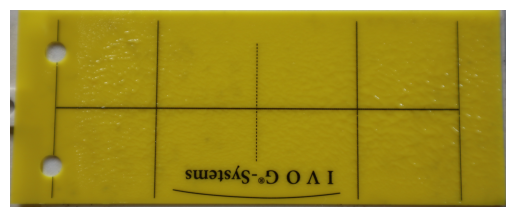

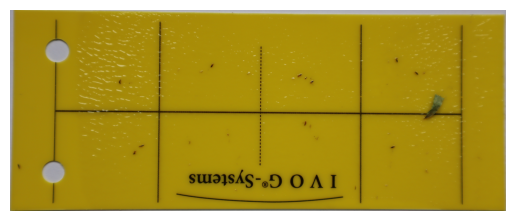

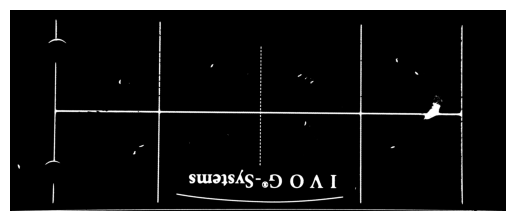

NameError: name 'cropped' is not defined

In [6]:
grid_image = cv2.imread("/user/christoph.wald/u15287/big-scratch/empty_YST/IMG_5885.JPG")
grid_image,_ = crop(grid_image)
path = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/test_set/images"
files = os.listdir(path)
image_with_objects = cv2.imread(os.path.join(path, files[0]))
show(grid_image)
show(image_with_objects)
points_grid = find_keypoints(image_with_objects, plot=True)
points_object = find_keypoints(grid_image, plot=True)